Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator

Parameters

In [1]:
path=r"C:\Users\umite\Desktop\vs_yapay_zeka\Traffic Sign Classification\Data"
label_file=r"C:\Users\umite\Desktop\vs_yapay_zeka\Traffic Sign Classification\labels\labels.csv"
batch_size_val=50
steps_per_epoch_val=2000
epochs_val=10
image_shape=(32,32,3)
test_ratio=0.2
validation_ratio=0.2

Loading Images

In [3]:
count=0
images=[]
class_no=[]
my_list=os.listdir(path)
print("Total Classes Detected: ",len(my_list))
no_of_classes=len(my_list)
print("Loading Classes......")
for i in range(0,len(my_list)):
    my_pic_list=os.listdir(path+"/"+str(count))
    for j in my_pic_list:
        cur_img=cv2.imread(path+"/"+str(count)+"/"+j)
        images.append(cur_img)
        class_no.append(count)
    print(count,end=" ")
    count=count+1
print(" ")
images=np.array(images)
class_no=np.array(class_no)

Total Classes Detected:  43
Loading Classes......
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


Train-Test Split

In [4]:
X_train, X_test, y_train, y_test=train_test_split(images,class_no,test_size=test_ratio)
X_train, X_validation, y_train, y_validation=train_test_split(X_train,y_train,test_size=validation_ratio)

Reading Label File

In [5]:
data=pd.read_csv(label_file)
print("data shape ",data.shape,type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


Functions to Preproces Images

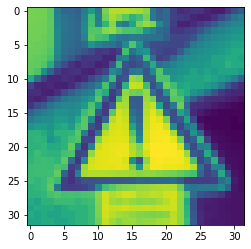

In [6]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img
 
X_train=np.array(list(map(preprocessing,X_train)))
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))
plt.imshow(X_train[random.randint(0,len(X_train)-1)])

Adding Depth

In [7]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

Image Augmentation

In [8]:
dataGen= ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10)
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=20)
X_batch,y_batch = next(batches)

Converting 'y' Numerical to Categorical

In [9]:
y_train = to_categorical(y_train,no_of_classes)
y_validation = to_categorical(y_validation,no_of_classes)
y_test = to_categorical(y_test,no_of_classes)

Creating Model

In [10]:
def myModel():
    no_of_Filters=60
    size_of_Filter=(5,5)
    size_of_Filter2=(3,3)
    size_of_pool=(2,2)
    no_Of_Nodes = 500
    model= Sequential()
    model.add((Conv2D(no_of_Filters,size_of_Filter,input_shape=(image_shape[0],image_shape[1],1),activation='relu')))
    model.add((Conv2D(no_of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
 
    model.add((Conv2D(no_of_Filters//2, size_of_Filter2,activation='relu')))
    model.add((Conv2D(no_of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))
 
    model.add(Flatten())
    model.add(Dense(no_Of_Nodes,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(no_of_classes,activation='softmax'))
    # COMPILE MODEL
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

Training Model

In [12]:
model = myModel()
print(model.summary())
history=model.fit_generator(dataGen.flow(X_train,y_train,batch_size=batch_size_val),epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 60)        1560      
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

C:\Users\umite\AppData\Local\Temp/ipykernel_17988/3216716611.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(dataGen.flow(X_train,y_train,batch_size=batch_size_val),epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)


446/446 [==============================] - 73s 161ms/step - loss: 2.7308 - accuracy: 0.2457 - val_loss: 1.0953 - val_accuracy: 0.6755
Epoch 2/10
446/446 [==============================] - 74s 167ms/step - loss: 1.3638 - accuracy: 0.5808 - val_loss: 0.3812 - val_accuracy: 0.8940
Epoch 3/10
446/446 [==============================] - 75s 168ms/step - loss: 0.8947 - accuracy: 0.7200 - val_loss: 0.2207 - val_accuracy: 0.9398
Epoch 4/10
446/446 [==============================] - 72s 161ms/step - loss: 0.6903 - accuracy: 0.7820 - val_loss: 0.1611 - val_accuracy: 0.9542
Epoch 5/10
446/446 [==============================] - 70s 157ms/step - loss: 0.5647 - accuracy: 0.8193 - val_loss: 0.1134 - val_accuracy: 0.9743
Epoch 6/10
446/446 [==============================] - 72s 161ms/step - loss: 0.4966 - accuracy: 0.8438 - val_loss: 0.0992 - val_accuracy: 0.9705
Epoch 7/10
446/446 [==============================] - 70s 156ms/step - loss: 0.4375 - accuracy: 0.8616 - val_loss: 0.0925 - val_accuracy: 0.9

Plotting Training-Test Accuracy and Loss

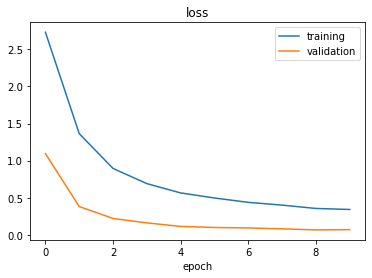

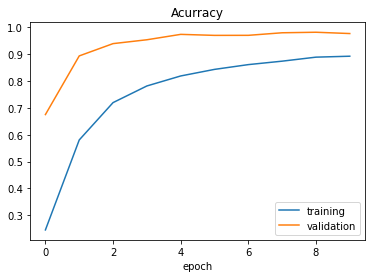

Test Score: 0.07640325278043747
Test Accuracy: 0.9761494398117065


In [13]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

Saving Model

In [14]:
model.save("saved_trained_model")

INFO:tensorflow:Assets written to: saved_trained_model\assets


INFO:tensorflow:Assets written to: saved_trained_model\assets
